## House Prices

### It is your job to predict the sales price for each house

In [3]:
import pathlib
path = pathlib.Path('/storage/archive/house_prices')

from kaggle import api
if not path.exists():
    path.mkdir()
    api.competition_download_cli('house-prices-advanced-regression-techniques', path=path)

In [4]:
import zipfile
with zipfile.ZipFile(path/'house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
list(path.glob('*'))

[Path('/storage/archive/house_prices/sample_submission.csv'),
 Path('/storage/archive/house_prices/data_description.txt'),
 Path('/storage/archive/house_prices/test.csv'),
 Path('/storage/archive/house_prices/house-prices-advanced-regression-techniques.zip'),
 Path('/storage/archive/house_prices/train.csv')]

In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import pathlib

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## The Data

In [2]:
path = pathlib.Path('/storage/archive/house_prices')
df = pd.read_csv(path/'train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,...,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,...,2008,WD,Normal,208500
1,2,20,RL,80.0,...,2007,WD,Normal,181500
2,3,60,RL,68.0,...,2008,WD,Normal,223500
3,4,70,RL,60.0,...,2006,WD,Abnorml,140000
4,5,60,RL,84.0,...,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,...,2007,WD,Normal,175000
1456,1457,20,RL,85.0,...,2010,WD,Normal,210000
1457,1458,70,RL,66.0,...,2010,WD,Normal,266500
1458,1459,20,RL,68.0,...,2010,WD,Normal,142125


In [3]:
print(len(df.columns))
df.columns

81


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Define the categorial ordinal variables

In [4]:
qual = ['Ex','Gd','TA','Fa','Po']

df['ExterQual'] = df['ExterQual'].astype('category')
df['ExterQual'].cat.set_categories(qual, ordered = True, inplace = True)

In [5]:
df['ExterCond'] = df['ExterCond'].astype('category')
df['ExterCond'].cat.set_categories(qual, ordered = True, inplace = True)

In [6]:
df['BsmtQual'] = df['BsmtQual'].astype('category')
df['BsmtQual'].cat.set_categories(qual, ordered = True, inplace = True)

In [7]:
df['BsmtCond'] = df['BsmtCond'].astype('category')
df['BsmtCond'].cat.set_categories(qual, ordered = True, inplace = True)

In [8]:
df['HeatingQC'] = df['HeatingQC'].astype('category')
df['HeatingQC'].cat.set_categories(qual, ordered = True, inplace = True)

In [9]:
df['KitchenQual'] = df['KitchenQual'].astype('category')
df['KitchenQual'].cat.set_categories(qual, ordered = True, inplace = True)

In [10]:
df['FireplaceQu'] = df['FireplaceQu'].astype('category')
df['FireplaceQu'].cat.set_categories(qual, ordered = True, inplace = True)

In [11]:
df['GarageQual'] = df['GarageQual'].astype('category')
df['GarageQual'].cat.set_categories(qual, ordered = True, inplace = True)

In [12]:
df['GarageCond'] = df['GarageCond'].astype('category')
df['GarageCond'].cat.set_categories(qual, ordered = True, inplace = True)

In [13]:
df['PoolQC'] = df['PoolQC'].astype('category')
df['PoolQC'].cat.set_categories(qual, ordered = True, inplace = True)

## Depented variable

In [14]:
dep_var = 'SalePrice'

In [15]:
df[dep_var] = np.log(df[dep_var])

## Create the dataset from the df:
- **procs**
    - Categorify: switch categorial variable to integers
    - FillMissing: fill missing data with the median
- Define categorial and continues variables
- split the data to train and validation

In [16]:
procs = [Categorify, FillMissing]

In [17]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [18]:
f = RandomSplitter(seed=42)
f(df)

((#1168) [1172,1313,1327,29,397,999,1406,219,436,482...],
 (#292) [782,131,414,1350,190,820,1376,1040,1314,305...])

In [19]:
database = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=f(df))

In [20]:
len(database.train), len(database.valid)

(1168, 292)

In [21]:
database.show(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1172,FV,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,#na#,Detchd,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,1173,160,35.0,4017,7,5,2006,2007,0.0,0,0,625,625,625,625,0,1250,0,0,2,1,2,1,5,0,2006.0,2,625,0,54,0,0,0,0,0,3,2008,12.054668
1313,RL,Pave,#na#,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,BuiltIn,Fin,TA,TA,Y,#na#,#na#,#na#,WD,Normal,False,False,False,1314,60,108.0,14774,9,5,1999,1999,165.0,0,0,1393,1393,1422,1177,0,2599,0,0,2,1,4,1,10,1,1999.0,3,779,668,30,0,0,0,0,0,5,2010,12.716402
1327,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,Gd,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Ex,Attchd,Unf,TA,TA,Y,#na#,MnPrv,#na#,WD,Normal,False,False,False,1328,20,60.0,6600,5,9,1982,2008,0.0,641,0,175,816,816,0,0,816,0,1,1,0,3,1,5,1,1982.0,1,264,0,0,0,0,0,0,0,10,2008,11.779128


when using show() tha data locks original with strings.

but actually with items, can see the transform to integers

In [22]:
database.items.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,...,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
1172,1173,160,2,35.0,...,12.054668,1,1,1
1313,1314,60,4,108.0,...,12.716402,1,1,1
1327,1328,20,4,60.0,...,11.779128,1,1,1


In [23]:
xs = database.train.xs
y = database.train.y
valid_xs = database.valid.xs
valid_y = database.valid.y

## Naive approach

predict the mean house price

In [24]:
y.mean()

12.013202

In [25]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [26]:
r_mse(y.mean(),y)

0.400664

## Decision Trees

In [27]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y)

DecisionTreeRegressor(max_leaf_nodes=4)

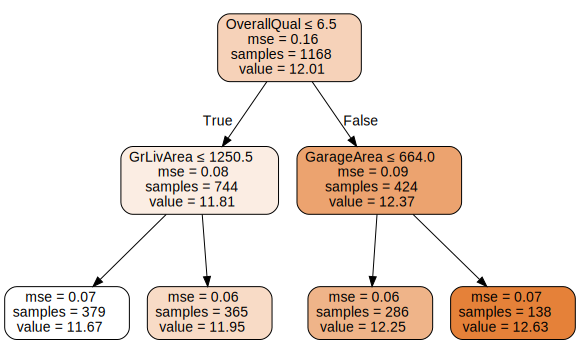

In [28]:
draw_tree(m,xs,size=10, leaves_parallel=True, precision=2)

In [29]:
for i in range(1,15):
    m = DecisionTreeRegressor(min_samples_leaf=i)
    m.fit(xs, y)
    print(f"min_samples_leaf {i}, n_leaves {m.get_n_leaves()}, rmse train: {m_rmse(m, xs, y)}, rmse validation: {m_rmse(m, valid_xs, valid_y)}")

min_samples_leaf 1, n_leaves 1117, rmse train: 0.0, rmse validation: 0.189638
min_samples_leaf 2, n_leaves 514, rmse train: 0.044098, rmse validation: 0.195136
min_samples_leaf 3, n_leaves 323, rmse train: 0.066769, rmse validation: 0.18879
min_samples_leaf 4, n_leaves 235, rmse train: 0.085262, rmse validation: 0.192398
min_samples_leaf 5, n_leaves 192, rmse train: 0.097154, rmse validation: 0.200287
min_samples_leaf 6, n_leaves 155, rmse train: 0.10824, rmse validation: 0.194179
min_samples_leaf 7, n_leaves 133, rmse train: 0.114819, rmse validation: 0.18335
min_samples_leaf 8, n_leaves 115, rmse train: 0.120069, rmse validation: 0.189397
min_samples_leaf 9, n_leaves 104, rmse train: 0.127596, rmse validation: 0.18868
min_samples_leaf 10, n_leaves 93, rmse train: 0.133169, rmse validation: 0.176017
min_samples_leaf 11, n_leaves 84, rmse train: 0.135395, rmse validation: 0.177464
min_samples_leaf 12, n_leaves 75, rmse train: 0.141313, rmse validation: 0.179819
min_samples_leaf 13, n_l

The best decision tree gets the score: 0.176. great improvment from 0.4

## Random Forest

In [30]:
def rf(xs, y, n_estimators=50, max_samples=650, max_features=0.5, min_samples_leaf=7, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [31]:
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.125048, 0.1358)

Another improvment with random forest our score is 0.1358

## Feature Importence

which Features are most importent for the prediction

In [32]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [33]:
fi = rf_feat_importance(m, xs)
fi[:15]

,cols,imp
50,OverallQual,0.326973
62,GrLivArea,0.154966
72,GarageCars,0.076246
18,ExterQual,0.069261
58,TotalBsmtSF,0.048693
52,YearBuilt,0.046786
73,GarageArea,0.043116
59,1stFlrSF,0.026942
30,KitchenQual,0.022420
55,BsmtFinSF1,0.022401


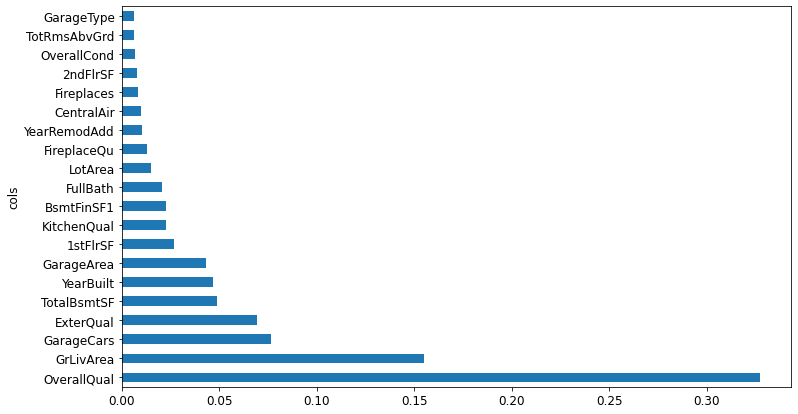

In [34]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:20]);

The most important features are OverallQual (Rates the overall material and finish of the house) and GrLivArea (Above ground living area square feet).

On the other hand it seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results.

In [35]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep), len(fi.cols)

(20, 83)

In [36]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [37]:
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.129939, 0.136647)

with only 20 features insted of 83 we still get the same results, 0.136

## Redundant Features

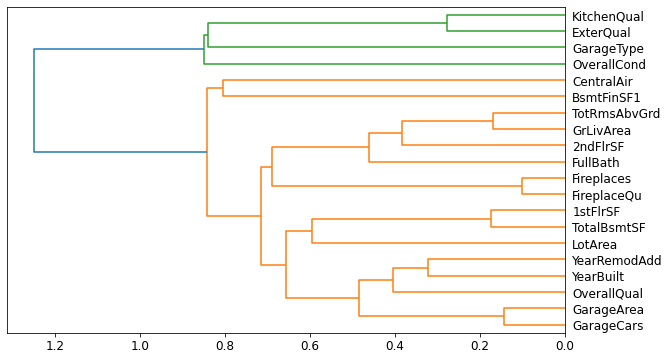

In [40]:
cluster_columns(xs_imp)

we acn see that some features are simmilar like GarageArea and GarageCars, and FireplaceQu and Fireplaces

In [41]:
to_drop = ['Fireplaces','GarageArea']
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [42]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.129483, 0.136339)

despite removing another 2 features the same result.

## Partial Dependence

what is the relationship between the featurs and sale price

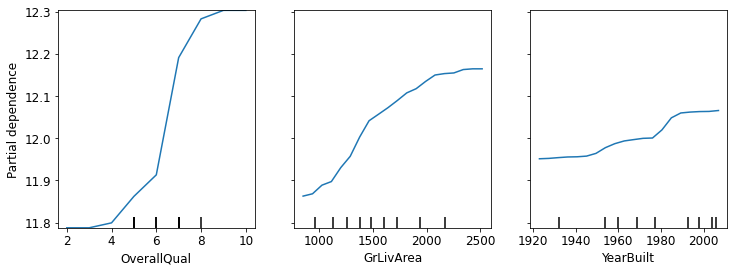

In [43]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['OverallQual','GrLivArea','YearBuilt'],
                        grid_resolution=20, ax=ax);

as 'OverallQual' 'GrLivArea' 'YearBuilt' raise also the asle price go up

## Tree Interpreter

In [44]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [46]:
row = valid_xs_final.iloc[:5]
row

,OverallQual,GrLivArea,GarageCars,ExterQual,...,2ndFlrSF,OverallCond,TotRmsAbvGrd,GarageType
782,7,1430,2,2,...,0,5,6,2
131,6,2054,2,2,...,1032,5,7,4
414,7,2097,3,2,...,1017,5,9,2
1350,5,2634,4,3,...,1296,5,12,6
190,8,2727,2,2,...,1178,8,10,6


In [47]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction, contributions[0]

(array([[12.24191579],
        [12.28064003],
        [12.47674616],
        [11.9640022 ],
        [12.51728804]]),
 array([ 0.15027619, -0.05054592, -0.02485576,  0.05843916,  0.03746193,  0.03655866,  0.00081262,  0.01200636, -0.01594164,  0.00502094,  0.02348671, -0.00377674,  0.00065367,  0.        ,
        -0.00881323,  0.        , -0.00030748,  0.01226557]))

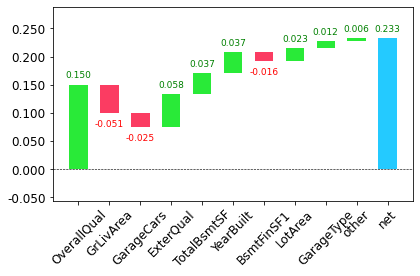

In [49]:
waterfall(valid_xs_final.columns, contributions[0],  threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');

we focus on one line. the 0.000 is predicting the mean (12.01) as the price, but the 'OverallQual' raise the price to 12.01+0.15 and so on we can see how each feature influence the final prediction

## Neural Network

in a neural net we use embeddings to handle categorical variables

In [50]:
df_nn = df.copy()
df_nn

,Id,MSSubClass,MSZoning,LotFrontage,...,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,...,2008,WD,Normal,12.247694
1,2,20,RL,80.0,...,2007,WD,Normal,12.109011
2,3,60,RL,68.0,...,2008,WD,Normal,12.317167
3,4,70,RL,60.0,...,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,...,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,...,2007,WD,Normal,12.072541
1456,1457,20,RL,85.0,...,2010,WD,Normal,12.254863
1457,1458,70,RL,66.0,...,2010,WD,Normal,12.493130
1458,1459,20,RL,68.0,...,2010,WD,Normal,11.864462


In [51]:
df_nn_final = df_nn[list(xs_final.columns) + [dep_var]] 

In [52]:
count_nn, cat_nn = cont_cat_split(df_nn_final, max_card=50, dep_var=dep_var)

In [53]:
procs_nn = [Categorify, FillMissing, Normalize]

In [54]:
db_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, count_nn, splits=f(df_nn_final), y_names=dep_var)

In [55]:
dls= db_nn.dataloaders(bs = 32)

In [56]:
y =  db_nn.train.y
y.min(), y.max()

(10.460242, 13.534473)

In [61]:
learn = tabular_learner(dls, y_range=(10,14), layers=[200,100], n_out=1, loss_func=F.mse_loss)

In [62]:
learn.fit_one_cycle(5,0.005)

epoch,train_loss,valid_loss,time
0,0.059125,0.041005,00:00
1,0.052003,0.029792,00:00
2,0.041680,0.019945,00:00
3,0.030857,0.016228,00:00
4,0.023317,0.015961,00:00


In [63]:
preds,targs = learn.get_preds()

In [64]:
r_mse(preds,targs)

0.126337

That is improvment!

now let's combine the nn and the RF results

In [65]:
rf_preds = m.predict(valid_xs_final)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [66]:
r_mse(ens_preds,valid_y)

0.123475

Another improvment!

Lets try train a rf model but instead of the categorail featurs we use the embbeding from the nn 

In [67]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(11, 6)
    (1): Embedding(6, 4)
    (2): Embedding(6, 4)
    (3): Embedding(6, 4)
    (4): Embedding(5, 4)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(10, 6)
    (8): Embedding(13, 7)
    (9): Embedding(7, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=55, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=10, hig

In [68]:
learn.model.embeds[0].weight

Parameter containing:
tensor([[ 0.0083, -0.0017,  0.0101, -0.0095, -0.0059, -0.0106],
        [-0.0095, -0.0097,  0.0214,  0.0076, -0.0173, -0.0185],
        [ 0.0227, -0.0496,  0.0313,  0.0104, -0.0152, -0.0404],
        [ 0.0300, -0.0364, -0.0081, -0.0163, -0.0114, -0.0360],
        [ 0.0211, -0.0236, -0.0003, -0.0012, -0.0117,  0.0118],
        [-0.0330, -0.0221,  0.0031,  0.0258, -0.0127,  0.0142],
        [-0.0115,  0.0337, -0.0273, -0.0228,  0.0084, -0.0201],
        [ 0.0031,  0.0346, -0.0090, -0.0174,  0.0479,  0.0117],
        [ 0.0011,  0.0018,  0.0216,  0.0097,  0.0195, -0.0026],
        [ 0.0246,  0.0067,  0.0335, -0.0156,  0.0046, -0.0036],
        [ 0.0053, -0.0110,  0.0187, -0.0197, -0.0042, -0.0078]], device='cuda:0', requires_grad=True)

In [69]:
db_nn.classes

{'OverallQual': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'GarageCars': ['#na#', 0, 1, 2, 3, 4],
 'ExterQual': ['#na#', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'KitchenQual': ['#na#', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'FullBath': ['#na#', 0, 1, 2, 3],
 'FireplaceQu': ['#na#', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'CentralAir': ['#na#', 'N', 'Y'],
 'OverallCond': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'TotRmsAbvGrd': ['#na#', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14],
 'GarageType': ['#na#', '2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd']}

In [70]:
big_dict = {}
for i,(k,v) in enumerate(db_nn.classes.items()):
    #print(i,k,v)
    big_dict[k] = {}
    for index, val in enumerate(v):
        arr = list(map(str,list(to_np(learn.model.embeds[i].weight[index]))))
        #print(",".join(arr))
        big_dict[k][str(val)]= ",".join(arr)


In [71]:
big_dict['OverallQual']

{'#na#': '0.008282305,-0.0017141495,0.010090769,-0.009520968,-0.0058871093,-0.01061672',
 '1': '-0.009461318,-0.009693944,0.021400558,0.007606051,-0.017286189,-0.018537166',
 '2': '0.022675548,-0.04964634,0.031322498,0.010403278,-0.015194623,-0.04043179',
 '3': '0.030002927,-0.03641843,-0.008072765,-0.016337637,-0.011395765,-0.035960987',
 '4': '0.021109724,-0.02360068,-0.00034901974,-0.0012241121,-0.011655446,0.011844842',
 '5': '-0.03297218,-0.022128941,0.0030574577,0.025781328,-0.012730623,0.0141961165',
 '6': '-0.011466596,0.033662282,-0.027329754,-0.022771489,0.008430316,-0.020102154',
 '7': '0.003093369,0.034608606,-0.009012237,-0.017427012,0.047871724,0.011650165',
 '8': '0.0011224428,0.0017790395,0.021631751,0.009731476,0.019510224,-0.0026293946',
 '9': '0.024645874,0.0067465384,0.033452522,-0.015635902,0.0045587574,-0.003577368',
 '10': '0.0052668727,-0.010979236,0.018660357,-0.019670198,-0.0042175944,-0.0077790325'}

In [74]:
df_rf_emb = df_nn_final.copy()

In [73]:
df_rf_emb['OverallQual'] = df_rf_emb['OverallQual'].astype(str)
df_rf_emb['OverallQual'] = df_rf_emb['OverallQual'].replace(big_dict['OverallQual'])# big_dict['OverallQual']
df_rf_emb

,OverallQual,GrLivArea,GarageCars,ExterQual,...,OverallCond,TotRmsAbvGrd,GarageType,SalePrice
0,"0.003093369,0.034608606,-0.009012237,-0.017427012,0.047871724,0.011650165",1710,2,Gd,...,5,8,Attchd,12.247694
1,"-0.011466596,0.033662282,-0.027329754,-0.022771489,0.008430316,-0.020102154",1262,2,TA,...,8,6,Attchd,12.109011
2,"0.003093369,0.034608606,-0.009012237,-0.017427012,0.047871724,0.011650165",1786,2,Gd,...,5,6,Attchd,12.317167
3,"0.003093369,0.034608606,-0.009012237,-0.017427012,0.047871724,0.011650165",1717,3,TA,...,5,7,Detchd,11.849398
4,"0.0011224428,0.0017790395,0.021631751,0.009731476,0.019510224,-0.0026293946",2198,3,Gd,...,5,9,Attchd,12.429216
...,...,...,...,...,...,...,...,...,...
1455,"-0.011466596,0.033662282,-0.027329754,-0.022771489,0.008430316,-0.020102154",1647,2,TA,...,5,7,Attchd,12.072541
1456,"-0.011466596,0.033662282,-0.027329754,-0.022771489,0.008430316,-0.020102154",2073,2,TA,...,6,7,Attchd,12.254863
1457,"0.003093369,0.034608606,-0.009012237,-0.017427012,0.047871724,0.011650165",2340,1,Ex,...,9,9,Attchd,12.493130
1458,"-0.03297218,-0.022128941,0.0030574577,0.025781328,-0.012730623,0.0141961165",1078,1,TA,...,6,5,Attchd,11.864462


In [163]:
df_rf_emb[['A','B','C','D']] = df_rf_emb['ExterQual'].str.split(',', expand=True)
df_rf_emb.drop(columns=['ExterQual'],inplace=True)

In [164]:
df_rf_emb

,OverallQual,GrLivArea,KitchenQual,GarageArea,...,A,B,C,D
0,7,1710,Gd,548,...,-0.042282816,-0.04388434,0.0127327265,-0.013515835
1,6,1262,TA,460,...,0.029612053,-0.007217533,-0.03617338,0.00893198
2,7,1786,Gd,608,...,-0.042282816,-0.04388434,0.0127327265,-0.013515835
3,7,1717,Gd,642,...,0.029612053,-0.007217533,-0.03617338,0.00893198
4,8,2198,Gd,836,...,-0.042282816,-0.04388434,0.0127327265,-0.013515835
...,...,...,...,...,...,...,...,...,...
1455,6,1647,TA,460,...,0.029612053,-0.007217533,-0.03617338,0.00893198
1456,6,2073,TA,500,...,0.029612053,-0.007217533,-0.03617338,0.00893198
1457,7,2340,Gd,252,...,-0.012458753,0.029152278,0.014180547,0.024788074
1458,5,1078,Gd,240,...,0.029612053,-0.007217533,-0.03617338,0.00893198


['OverallQual',
 'GarageCars',
 'ExterQual',
 'KitchenQual',
 'FullBath',
 'FireplaceQu',
 'CentralAir',
 'OverallCond',
 'TotRmsAbvGrd',
 'GarageType']

In [77]:
from_cat_to_emb = list(db_nn.classes.keys())
for cat in from_cat_to_emb:
    new_columns = []

    for i in range(len(list(big_dict[cat].values())[0].split(','))):
        new_columns.append(cat + '_' + str(i))
    
    
    df_rf_emb[cat] = df_rf_emb[cat].astype(str)
    df_rf_emb[cat] = df_rf_emb[cat].replace(big_dict[cat])
    df_rf_emb[new_columns] = df_rf_emb[cat].str.split(',', expand=True)
    df_rf_emb[new_columns] = df_rf_emb[new_columns].astype(float)
    df_rf_emb.drop(columns=[cat],inplace=True)

df_rf_emb

,GrLivArea,TotalBsmtSF,YearBuilt,1stFlrSF,...,GarageType_1,GarageType_2,GarageType_3,GarageType_4
0,1710,856,2003,856,...,0.004135,-0.002253,-0.016829,-0.009186
1,1262,1262,1976,1262,...,0.004135,-0.002253,-0.016829,-0.009186
2,1786,920,2001,920,...,0.004135,-0.002253,-0.016829,-0.009186
3,1717,756,1915,961,...,0.045105,0.024290,0.005672,-0.027146
4,2198,1145,2000,1145,...,0.004135,-0.002253,-0.016829,-0.009186
...,...,...,...,...,...,...,...,...,...
1455,1647,953,1999,953,...,0.004135,-0.002253,-0.016829,-0.009186
1456,2073,1542,1978,2073,...,0.004135,-0.002253,-0.016829,-0.009186
1457,2340,1152,1941,1188,...,0.004135,-0.002253,-0.016829,-0.009186
1458,1078,1078,1950,1078,...,0.004135,-0.002253,-0.016829,-0.009186


In [78]:
df_rf_emb[['OverallQual_0', 'OverallQual_1', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5']]

,OverallQual_0,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5
0,0.003093,0.034609,-0.009012,-0.017427,0.047872,0.011650
1,-0.011467,0.033662,-0.027330,-0.022771,0.008430,-0.020102
2,0.003093,0.034609,-0.009012,-0.017427,0.047872,0.011650
3,0.003093,0.034609,-0.009012,-0.017427,0.047872,0.011650
4,0.001122,0.001779,0.021632,0.009731,0.019510,-0.002629
...,...,...,...,...,...,...
1455,-0.011467,0.033662,-0.027330,-0.022771,0.008430,-0.020102
1456,-0.011467,0.033662,-0.027330,-0.022771,0.008430,-0.020102
1457,0.003093,0.034609,-0.009012,-0.017427,0.047872,0.011650
1458,-0.032972,-0.022129,0.003057,0.025781,-0.012731,0.014196


In [79]:
df_rf_emb['OverallQual']

KeyError: 'OverallQual'

great insted of one coulmn categorial feature we have the embbeding

In [80]:
procs = [Categorify, FillMissing]

In [81]:
cont,cat = cont_cat_split(df_rf_emb, 1, dep_var=dep_var)
len(cont), len(cat)

(55, 0)

In [82]:
to = TabularPandas(df_rf_emb, procs, cat, cont, y_names=dep_var, splits=f(df_rf_emb))

In [83]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [84]:
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.130199, 0.134588)

The results relative to the previous rf have improved slightly (13.6 to 13.4)

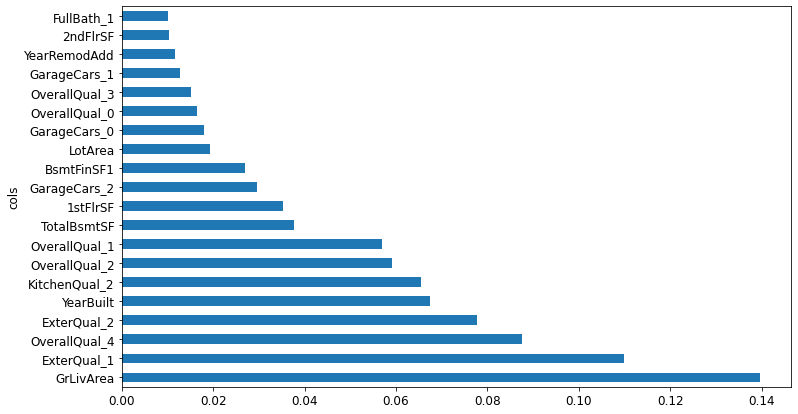

In [85]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:20]);